:The purpose of SkimLit is to make reading medical paper easier. An NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc..) to enable researchers to skim through the literature and dive deeper when necessary.

In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


Trying to replicate this paper https://arxiv.org/pdf/1710.06071.pdf , https://arxiv.org/pdf/1612.05251.pdf

we can get datasets from here https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 8.67 MiB/s, done.
Updating files: 100% (13/13), done.


In [ ]:
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os 
filenames=[data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
def get_lines(filename):
  with open(filename,'r') as f:
    return f.readlines()


In [ ]:
train_lines=get_lines(data_dir+"train.txt")

In [ ]:
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

In [ ]:
# list1=[]

# for i in train_lines:
#   if i[0]=='#' or i[0]=='\n':
#     pass
#   else:
#     l=i.split("\t")
#     print(l[1].replace('\n',''))
#     dict1={'target':l[0],
#            'text':l[1],
#            }
#     list1.append(dict1)
# print(list1[:2])

def preprocess_text_with_line_numbers(filename):
  input_lines=get_lines(filename)
  abstract_lines=""
  abstract_samples=[]
  for line in input_lines:
    if line.startswith("###"):
      abstract_id=line
      abstract_lines=""
    elif line.isspace():
      abstract_line_split=abstract_lines.splitlines()
      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        line_data={}
        target_text_split=abstract_line.split("\t")
        line_data["target"]=target_text_split[0]
        line_data["text"]=target_text_split[1].lower()
        line_data["line_number"]=abstract_line_number
        line_data["total_lines"]=len(abstract_line_split)-1
        abstract_samples.append(line_data)
    else:
      abstract_lines+=line
  return abstract_samples
  






In [ ]:
train_samples=preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples=preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples=preprocess_text_with_line_numbers(data_dir+"test.txt")

In [ ]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [ ]:
train_sentences=train_df['text'].tolist()
val_sentences=val_df['text'].tolist()
test_sentences=test_df['text'].tolist()

In [ ]:
train_df.target.value_counts().values

array([59353, 57953, 27168, 21727, 13839])

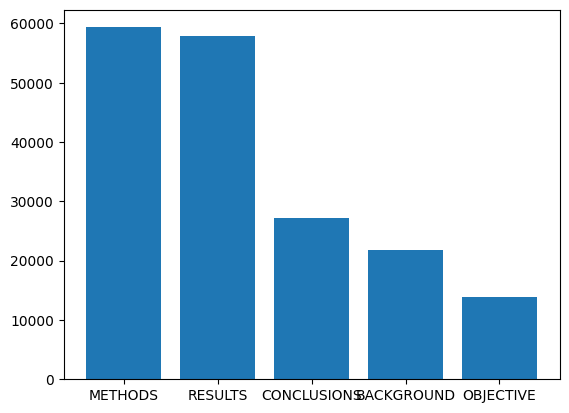

In [ ]:
import matplotlib.pyplot as plt
plt.bar(train_df.target.value_counts().index,train_df.target.value_counts().values)
plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded=label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded=label_encoder.fit_transform(test_df['target'].to_numpy())
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0=Pipeline([("tf-idf",TfidfVectorizer()),
                  ("clf",MultinomialNB())])
model_0.fit(X=train_sentences,y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X=val_sentences,y=val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
baseline_results=calculate_results(val_labels_encoded,baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

In [ ]:
sent_lens=[len(sentence.split()) for sentence in train_sentences]
avg_sent_len=np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

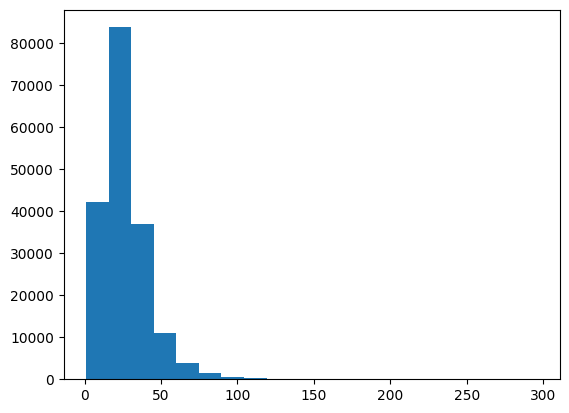

In [ ]:
plt.hist(sent_lens,bins=20)

In [ ]:
# calculating how long of a sentence cover 95% of example.
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

55

In [ ]:
from tensorflow.keras.layers import TextVectorization
text_vectorizer=TextVectorization(
    max_tokens=68000,  
    output_sequence_length=output_seq_len
)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence=random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
the proportion of patients with estimated glomerular filtration rate @ ml/min per @ m ( @ ) in the ldt + adv group increased from @ % ( @/@ ) at baseline to @ % ( @/@ ) at week @ , while that in the lam + adv group decreased from @ % ( @/@ ) at baseline to @ % ( @/@ ) at week @ .

Length of text: 69

Vectorized text: [[   2  443    4   12    7  597 2270 2123   78 2136  160  358    5    2
  8040 5156   13   96   27   15   49    6   15   89  258   28    5    2
  5829 5156   13  212   27   15   49    6   15   89    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
rct_20k_text_vocab=text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


# token embedding

In [ ]:
token_embed=layers.Embedding(input_dim=len(rct_20k_text_vocab),output_dim=128,mask_zero=True,name='token_embedding')

In [ ]:
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence=text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence=token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 the proportion of patients with estimated glomerular filtration rate @ ml/min per @ m ( @ ) in the ldt + adv group increased from @ % ( @/@ ) at baseline to @ % ( @/@ ) at week @ , while that in the lam + adv group decreased from @ % ( @/@ ) at baseline to @ % ( @/@ ) at week @ .

Sentence after vectorization (before embedding):
[[   2  443    4   12    7  597 2270 2123   78 2136  160  358    5    2
  8040 5156   13   96   27   15   49    6   15   89  258   28    5    2
  5829 5156   13  212   27   15   49    6   15   89    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[ 1.7283075e-03 -1.9819403e-02 -7.2799623e-05 ... -3.7063312e-02
    1.9965958e-02 -4.3044865e-02]
  [ 2.7052734e-02 -3.3064678e-02  5.4056272e-03 ... -3.4366325e-02
    1.7239559e-02 -1.0407280e-02]
  [ 4.7868554e-02 -4.1686632e-02  3.6407519e-02 ... -1.3592433e-02
   -2.7709438e-02 -2.2482026e-02]
  ...
  [-4.7393430e-

In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset=valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Conv1D with token embedding

In [ ]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs)
token_embeddings=token_embed(text_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_1=tf.keras.Model(inputs,outputs)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
history_model_1=model_1.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3,
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset))
                            )

Epoch 1/3
562/562 [==============================] - 72s 126ms/step - loss: 0.9184 - accuracy: 0.6379 - val_loss: 0.6817 - val_accuracy: 0.7404
Epoch 2/3
562/562 [==============================] - 67s 119ms/step - loss: 0.6544 - accuracy: 0.7590 - val_loss: 0.6305 - val_accuracy: 0.7699
Epoch 3/3
562/562 [==============================] - 68s 122ms/step - loss: 0.6175 - accuracy: 0.7745 - val_loss: 0.5984 - val_accuracy: 0.7812


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.5988 - accuracy: 0.7854


[0.5988134145736694, 0.7853502035140991]

In [ ]:
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs,model_1_pred_probs.shape

In [ ]:
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

In [ ]:
model_1_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_1_preds)
model_1_results

In [ ]:
baseline_results

# ***Transfering Learning*** from tensorflow hub

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer= hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable=False,name="universal_sentence_encoder")

In [ ]:
random_train_sentence=random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence=tf_hub_embedding_layer([random_train_sentence])
print(f"sentence after embedding:\n{use_embedded_sentence[:20]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

# Feature Extraction using pretrained embedding using tensorflow hub


In [ ]:
inputs=layers.Input(shape=[],dtype=tf.string)
pretrained_embedding=tf_hub_embedding_layer(inputs)
x=layers.Dense(128,activation='relu')(pretrained_embedding)
outputs=layers.Dense(num_classes,activation='softmax')(x)
model_2=tf.keras.Model(inputs=inputs,outputs=outputs,name="model_2_USE_feature_extractor")
model_2.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam()
,metrics=['accuracy'])

In [ ]:
model_2.summary()

In [ ]:
history_model_2=model_2.fit(train_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset))
                            )

In [ ]:
model_2.evaluate(valid_dataset)

In [ ]:
model_2_pred_probs=model_2.predict(valid_dataset)
model_2_pred_probs

In [ ]:
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

In [ ]:
model_2_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_2_preds)
model_2_results

# Conv1D with character embeddings

In [ ]:
def split_chars(text):
  return " ".join(list(text))

split_chars(random_train_sentence)

In [ ]:
train_chars=[split_chars(sentence) for sentence in train_sentences]
val_chars=[split_chars(sentence) for sentence in val_sentences]
test_chars=[split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

In [ ]:
char_lens=[len(sentence) for sentence in train_sentences]
mean_char_len=np.mean(char_lens)
mean_char_len

In [ ]:
plt.hist(char_lens,bins=7)

In [ ]:
output_seq_char_len=int(np.percentile(char_lens,95))
output_seq_char_len

In [ ]:
#get all the keyboard character so we use their len as max_token
import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
alphabet

In [ ]:
NUM_CHAR_TOKENS=len(alphabet)+2
char_vectorizer=TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_sequence_length=output_seq_char_len,
                                  name='char_vecotrizer',
                                  )

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab=char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab:{len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

In [ ]:
random_train_chars=random.choice(train_chars)
print(random_train_chars)
vectorized_chars=char_vectorizer([random_train_chars])
print(f"\vectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

# Creating a character-level embedding

In [ ]:
char_embed=layers.Embedding(input_dim=len(char_vocab),output_dim=25,
                            mask_zero=True,
                            name='char_embedding')


In [ ]:
print(f"char before vectorization:\n {random_train_chars}\n")
vectorized_char=char_vectorizer([random_train_chars])
print(f"Sentence after vectorization (before embedding):\n{vectorized_char}\n")
char_embed_example=char_embed(vectorized_char)
print(f" after embedding:\n {char_embed_example}\n")
print(f"Embedded sentence shape: {char_embed_example.shape}")

In [ ]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
char_vectors=char_vectorizer(inputs)
char_embeddings=char_embed(char_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(char_embeddings)
x=layers.GlobalMaxPool1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_3=tf.keras.Model(inputs,
                       outputs,
                       name='model_3_conv1d_char_embedding'
                       )
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_3.summary()

In [ ]:
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_dataset

In [ ]:
model_3_history=model_3.fit(train_char_dataset,
                            steps_per_epoch=int(0.1*len(train_char_dataset)),
                            epochs=3,
                            validation_data=val_char_dataset,
                            validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 23ms/step - loss: 1.2811 - accuracy: 0.4880 - val_loss: 1.0495 - val_accuracy: 0.5834
Epoch 2/3
562/562 [==============================] - 13s 23ms/step - loss: 1.0039 - accuracy: 0.6011 - val_loss: 0.9386 - val_accuracy: 0.6290
Epoch 3/3
562/562 [==============================] - 13s 23ms/step - loss: 0.9244 - accuracy: 0.6436 - val_loss: 0.8723 - val_accuracy: 0.6526


In [ ]:
model_3_pred_probs=model_3.predict(val_char_dataset)
model_3_pred_probs

In [ ]:
model_3_preds=tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

In [ ]:
model_3_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_3_preds)
model_3_results

# Combining pretrained token embedding with character embedding

In [ ]:
# token_inputs=layers.Input(shape=[],dtype=tf.string,name="token_input")
# token_embeddings=tf_hub_embedding_layer(token_inputs)
# token_output=layers.Dense(128,activation='relu')(token_embeddings)
# token_model=tf.keras.Model(inputs=token_inputs,
#                            outputs=token_output)

token_inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs)
token_embeddings=token_embed(text_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x)
token_outputs=layers.Dense(32,activation="relu")(x)
token_model=tf.keras.Model(inputs,outputs)


char_inputs=layers.Input(shape=(1,) ,dtype=tf.string,name='char_input')
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,
                          outputs=char_bi_lstm)

token_char_concat=layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                char_model.output])
#dropout layers is use to prevent overfitting.
combined_dropout=layers.Dropout(0.5)(token_char_concat)
combined_dense=layers.Dense(128,activation='relu')(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation='softmax')(final_dropout)

model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],
                       outputs=output_layer,
                       name="model_4_token_and_char_embeddings"
                       )

In [ ]:
model_4.summary()

In [ ]:
from keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# train_token_char_dataset=tf.data.Dataset.from_tensor_slices(((train_sentences,train_chars),train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
# val_token_char_dataset=tf.data.Dataset.from_tensor_slices(((val_sentences,val_chars),val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
# test_token_char_dataset=tf.data.Dataset.from_tensor_slices(((test_sentences,test_chars),test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset=tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))
train_char_token_dataset=train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset=tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))
val_char_token_dataset=val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_data=tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_char_token_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset=tf.data.Dataset.zip((test_char_token_data,test_char_token_labels))
test_char_token_dataset=test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# train_token_char_dataset

In [ ]:
train_char_token_dataset

In [ ]:
# model_4_history=model_4.fit(train_token_char_dataset,
#                             steps_per_epoch=int(0.1*len(train_token_char_dataset)),
#                             epochs=3,
#                             validation_data=val_token_char_dataset,
#                             validation_steps=int(0.1*len(val_token_char_dataset)))

In [ ]:
model_4_history=model_4.fit(train_char_token_dataset,
                            steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                            epochs=3,
                            validation_data=val_char_token_dataset,
                            validation_steps=int(0.1*len(val_char_token_dataset)))

In [ ]:
model_4.evaluate(val_char_token_dataset)

In [ ]:
model_4_pred_probs=model_4.predict(val_char_token_dataset)

In [ ]:
model_4_preds=tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

In [ ]:
model_4_results=calculate_results(y_true=val_labels_encoded,y_pred=model_4_preds)
model_4_results

In [ ]:
model_1_results

# token_embedding+character_embedding+positional_embedding

In [ ]:
train_df.head()

In [ ]:
train_df['line_number'].value_counts()

In [ ]:
train_line_numbers_one_hot=tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df['line_number'].to_numpy(),depth=15)
train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

In [ ]:
train_df['total_lines'].value_counts()

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
np.percentile(train_df.total_lines,98)

In [ ]:
train_total_lines_one_hot=tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_df['total_lines'].to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)
train_total_lines_one_hot.shape,train_total_lines_one_hot[:10]

# Tibrid Model
create token model and character model and concatenate them then create model with line_number and total_line feature and concatenate all the model.

In [ ]:
#token model
token_inputs=layers.Input(shape=[],dtype="string",name="token_input")
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_outputs=layers.Dense(128,activation='relu')(token_embeddings)
token_model=tf.keras.Model(inputs=token_inputs,outputs=token_outputs)
# token_inputs=layers.Input(shape=(1,),dtype=tf.string)
# text_vectors=text_vectorizer(inputs)
# token_embeddings=token_embed(text_vectors)
# x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
# x=layers.GlobalAveragePooling1D()(x)
# token_outputs=layers.Dense(32,activation="relu")(x)
# token_model=tf.keras.Model(inputs,outputs)

#character model 
# here the shape is(1,) because When using `TextVectorization` 
#to tokenize strings, 
#the input rank must be 1 or the last shape dimension must be 1
char_inputs=layers.Input(shape=(1,),dtype="string",name='char_inputs')
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,outputs=char_bi_lstm)
#line_number model
#for input shape check the shape of 1st element of one_hot_encoded data
line_number_inputs=layers.Input(shape=(15,),dtype=tf.float32,name="line_number_input")
x=layers.Dense(32,activation='relu')(line_number_inputs)
line_number_model=tf.keras.Model(inputs=line_number_inputs,outputs=x)

#total lines model
total_lines_inputs=layers.Input(shape=(20,),dtype=tf.float32,name="total_lines_input")
y=layers.Dense(32,activation='relu')(total_lines_inputs)
total_line_model=tf.keras.Model(inputs=total_lines_inputs,outputs=y)

# combine token and char model
combined_embeddings=layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output,
                                                                           char_model.output])
z=layers.Dense(256,activation='relu')(combined_embeddings)
z=layers.Dropout(0.5)(z)
# positional embedding with combine embedding
tribrid_embeddings=layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                               total_line_model.output,
                                                                               z
                                                                               ])
output_layer=layers.Dense(num_classes,activation="softmax",name='output_layer')(tribrid_embeddings)
model_5=tf.keras.Model(inputs=[line_number_model.input,
                               total_line_model.input,
                               token_model.input,
                               char_model.input],
                       outputs=output_layer,
                       name='model_5_tribrid_embedding_model')

In [ ]:
model_5.summary()

In [ ]:
plot_model(model_5,show_shapes=True)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),#helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


# tribrid tf.data

In [ ]:
train_char_token_pos_data=tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                              train_total_lines_one_hot,
                                                              train_sentences,
                                                              train_chars))
train_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset=tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))
train_char_token_pos_dataset=train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


val_char_token_pos_data=tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset=tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))
val_char_token_pos_dataset=val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


test_char_token_pos_data=tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                              test_total_lines_one_hot,
                                                              test_sentences,
                                                              test_chars))
test_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset=tf.data.Dataset.zip((test_char_token_pos_data,test_char_token_pos_labels))
test_char_token_pos_dataset=test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_pos_dataset

In [ ]:
model_5_history=model_5.fit(train_char_token_pos_dataset,
                            steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                            epochs=3,
                            validation_data=val_char_token_pos_dataset,
                            validation_steps=int(0.1*len(val_char_token_pos_dataset)))

In [ ]:
model_5.evaluate(val_char_token_pos_dataset)

In [ ]:
model_5_pred_probs=model_5.predict(val_char_token_pos_dataset)

In [ ]:
model_5_preds=tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

In [ ]:
model_5_results=calculate_results(y_true=val_labels_encoded,y_pred=model_5_preds)
model_5_results

In [ ]:
all_model_results=pd.DataFrame({"model_0_baseline":baseline_results,
                                "model_1_custom_token_embedding":model_1_results,
                                "model_2_pretrained_token_embedding":model_2_results,
                                "model_3_hybrid_char_token_embedding":model_3_results,
                                "model_4_hybrid_char_token_embedding":model_4_results,
                                "model_5_pos_char_token_embedding":model_5_results})
all_model_results

In [ ]:
all_model_results=all_model_results.transpose()
all_model_results

In [ ]:
all_model_results['accuracy']=all_model_results['accuracy']/100

In [ ]:
all_model_results.plot(kind='bar',figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

# Model 6

In [ ]:
# #token model

# token_inputs=layers.Input(shape=(1,),dtype=tf.string)
# text_vectors=text_vectorizer(inputs)
# token_embeddings=token_embed(text_vectors)
# x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
# x=layers.GlobalAveragePooling1D()(x)
# token_outputs=layers.Dense(32,activation="relu")(x)
# token_model=tf.keras.Model(inputs,outputs)


# #line_number model
# #for input shape check the shape of 1st element of one_hot_encoded data
# line_number_inputs=layers.Input(shape=(15,),dtype=tf.float32,name="line_number_input")
# x=layers.Dense(32,activation='relu')(line_number_inputs)
# line_number_model=tf.keras.Model(inputs=line_number_inputs,outputs=x)

# #total lines model
# total_lines_inputs=layers.Input(shape=(20,),dtype=tf.float32,name="total_lines_input")
# y=layers.Dense(32,activation='relu')(total_lines_inputs)
# total_line_model=tf.keras.Model(inputs=total_lines_inputs,outputs=y)


# # positional embedding with combine embedding
# token_line_total_embeddings=layers.Concatenate(name="token_line_numbers_total_lines_hybrid_embedding")([line_number_model.output,
#                                                                                total_line_model.output,
#                                                                                token_model.output
#                                                                                ])
# output_layer=layers.Dense(num_classes,activation="softmax",name='output_layer')(token_line_total_embeddings)
# model_6=tf.keras.Model(inputs=[line_number_model.input,
#                                total_line_model.input,
#                                token_model.input,
#                                ],
#                        outputs=output_layer,
#                        name='model_6_tribrid_embedding_model')

In [ ]:
# model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),#helps to prevent overfitting
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=['accuracy'])

In [ ]:
# train_token_pos_data=tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
#                                                               train_total_lines_one_hot,
#                                                               train_sentences,
#                                                               ))
# train_token_pos_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
# train_token_pos_dataset=tf.data.Dataset.zip((train_token_pos_data,train_token_pos_labels))
# train_token_pos_dataset=train_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# val_token_pos_data=tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
#                                                               val_total_lines_one_hot,
#                                                               val_sentences,
#                                                               ))
# val_token_pos_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
# val_token_pos_dataset=tf.data.Dataset.zip((val_token_pos_data,val_token_pos_labels))
# val_token_pos_dataset=val_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# test_token_pos_data=tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
#                                                               test_total_lines_one_hot,
#                                                               test_sentences,
#                                                               ))
# test_token_pos_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
# test_token_pos_dataset=tf.data.Dataset.zip((test_token_pos_data,test_token_pos_labels))
# test_token_pos_dataset=test_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# train_token_pos_dataset

In [ ]:
# model_6_history=model_6.fit(train_token_pos_dataset,
#                             steps_per_epoch=int(0.1*len(train_token_pos_dataset)),
#                             epochs=3,
#                             validation_data=val_token_pos_dataset,
#                             validation_steps=int(0.1*len(val_token_pos_dataset)))

In [ ]:
# model_6.evaluate(val_token_pos_dataset)

In [ ]:
# model_6_pred_probs=model_6.predict(val_token_pos_dataset)

In [ ]:
# model_6_preds=tf.argmax(model_6_pred_probs,axis=1)
# model_6_preds

In [ ]:
# model_6_results=calculate_results(y_true=val_labels_encoded,y_pred=model_6_preds)
# model_6_results

In [ ]:
# all_model_results=pd.DataFrame({"model_0_baseline":baseline_results,
#                                 "model_1_custom_token_embedding":model_1_results,
#                                 "model_2_pretrained_token_embedding":model_2_results,
#                                 "model_3_hybrid_char_token_embedding":model_3_results,
#                                 "model_4_hybrid_char_token_embedding":model_4_results,
#                                 "model_5_pos_char_token_embedding":model_5_results,
#                                 # "model_6_token_pos_embedding":model_6_results})
# all_model_results

In [ ]:
all_model_results=all_model_results.transpose()
all_model_results

In [ ]:
all_model_results=pd.DataFrame({"model_0_baseline":baseline_results,
                                "model_1_custom_token_embedding":model_1_results,
                                "model_2_pretrained_token_embedding":model_2_results,
                                "model_3_hybrid_char_token_embedding":model_3_results,
                                "model_4_hybrid_char_token_embedding":model_4_results,
                                "model_5_pos_char_token_embedding":model_5_results})
all_model_results

In [ ]:
all_model_results=all_model_results.transpose()
all_model_results

In [ ]:
all_model_results.sort_values("f1",ascending=True)["f1"].plot(kind='bar',figsize=(10,7))

# Save and load model

In [ ]:
model_5.save("skimlit_tribrid_model")

In [ ]:
loaded_model=tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
list(train_char_token_pos_data.as_numpy_iterator())

In [ ]:
loaded_pred_probs=loaded_model.predict(val_char_token_pos_dataset)
loaded_preds=tf.argmax(loaded_pred_probs,axis=1)
loaded_preds[:10]

In [ ]:
type(train_char_token_pos_data)

In [ ]:
# from sklearn.metrics import confusion_matrix

In [ ]:
# cm = confusion_matrix(val_labels_encoded, model_5_preds)
# cm